<a href="https://colab.research.google.com/github/shoebNTU/HelloWorld/blob/master/Batch_OnlineML_11DecData_noMix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install git+https://github.com/online-ml/river --upgrade

  Cloning https://github.com/online-ml/river to /tmp/pip-req-build-9dx2rg56
  Running command git clone -q https://github.com/online-ml/river /tmp/pip-req-build-9dx2rg56
  Created wheel for river: filename=river-0.1.0-cp36-cp36m-linux_x86_64.whl size=1581863 sha256=4a494e6b4d67f78240b0432f07399c0161e6600a59dce08f30d7269a029dba18
  Stored in directory: /tmp/pip-ephem-wheel-cache-vljk7d1g/wheels/1f/de/e2/d95d67b57b9a0639417cd656aecc8e5be88665ac5b63c2bd1b
Successfully built river
  Found existing installation: river 0.1.0
    Uninstalling river-0.1.0:
      Successfully uninstalled river-0.1.0


In [ ]:
!pip install XlsxWriter

In [ ]:
from river import datasets
from pprint import pprint
import pickle
import numpy as np
import os
import pandas as pd
from operator import itemgetter
import matplotlib.pyplot as plt
import pylab as plot
import xlsxwriter



In [ ]:
from sklearn import datasets
from sklearn import linear_model
from sklearn import metrics
from sklearn import model_selection
from sklearn import pipeline
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_score, cross_val_predict, GroupKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [ ]:
from river import compose
from river import linear_model
from river import metrics
from river import preprocessing
from river import optim

%matplotlib inline

In [ ]:
dataPath = '/content/drive/MyDrive/Material_data_11Dec_JR'
os.listdir(dataPath)#'/content/drive/MyDrive/Material_data_11Dec_JR')

In [ ]:
#Defining MAPE function
def MAPE(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

In [ ]:
for pickleFile in os.listdir(dataPath):

  if 'pickle' in pickleFile:
    with open(dataPath + '/' + pickleFile, 'rb') as handle:
      loaded_dict = pickle.load(handle)

    print(pickleFile + ' - ' + str(len(loaded_dict['title_run'])))  
       
 # ignoring sections 5356 and 5357 in analysis!   

In [ ]:
###### User input
train_percentage = 0.7
stage = 1
######

## Batch Learning, fixed

In [ ]:
cols = ['section_id',	'ex1_rpm-R2',	'ex1_rpm-MAPE',  'ex2_rpm-R2',	'ex2_rpm-MAPE', \
        'ex3_rpm-R2',	'ex3_rpm-MAPE','ex4_rpm-R2',	'ex4_rpm-MAPE', \
        'ex1_rpm-true', 'ex1_rpm-predicted','ex2_rpm-true', 'ex2_rpm-predicted','ex3_rpm-true', 'ex3_rpm-predicted','ex4_rpm-true', 'ex4_rpm-predicted']
df_test_results = pd.DataFrame(columns = cols)#(columns = ['section_id',	'ex1_rpm-R2',	'ex1_rpm-MSE',	'ex4_rpm-R2',	'ex4_rpm-MSE'])

scoring = 'neg_mean_absolute_error'#'neg_mean_squared_error'#'neg_mean_absolute_error'
scaler = StandardScaler()
# scaler = MinMaxScaler()


row_of_df = 0

for pickleFile in os.listdir(dataPath):

  if 'pickle' in pickleFile and '5356' not in pickleFile and '5357' not in pickleFile:
    
    with open(dataPath + '/' + pickleFile, 'rb') as handle:
      loaded_dict = pickle.load(handle)

    inputX = loaded_dict['inputs'][stage] # 1 for stage 1 and 2 for stage 2
    outputY = loaded_dict['outputs']
    groups = loaded_dict['title_run']

    col_not_mix = [c for c in inputX.columns if 'mixage' not in c]
    inputX=inputX[col_not_mix]

    #remove duplicates!
    inputX.drop_duplicates(inplace=True, keep="first") 
    outputY = outputY.loc[inputX.index,:]
    groups = groups.loc[inputX.index]
    
    # train-test split
    trainLen = int(train_percentage*inputX.shape[0])
    trainLen_cv_number = groups[:trainLen].unique().shape[0]

    # cross-validation
    cv_number = min(5,trainLen_cv_number) # if samples less than 5, do CV according to the length of training set
    cv = GroupKFold(cv_number)

    df_test_results.loc[row_of_df,'section_id'] = pickleFile.split('.')[0]

    # train
    parameters= {'n_components':range(1, inputX.shape[1]+1)}
    model = GridSearchCV(PLSRegression(), parameters, scoring=scoring, cv=cv)
    model.fit((inputX.values[:trainLen,:]), outputY.values[:trainLen], groups[:trainLen])

    #test
    y_pred = model.best_estimator_.predict((inputX.values[trainLen:,:]))
    # y_pred = cross_val_predict(model.best_estimator_, inputX.values, outputY.values, groups=groups, cv=GroupKFold(cv_number))

    #test metrics
    for ind,extruder in enumerate(outputY.columns.values):
      df_test_results.loc[row_of_df,extruder + '-R2'] = r2_score(outputY[extruder].values[trainLen:],y_pred[:,ind])
      df_test_results.loc[row_of_df,extruder + '-MAPE'] = MAPE(outputY[extruder].values[trainLen:],y_pred[:,ind])#mean_squared_error(outputY[extruder].values[trainLen:],y_pred[:,ind])

      df_test_results.loc[row_of_df,extruder + '-true'] = outputY[extruder].values
      df_test_results.loc[row_of_df,extruder + '-predicted'] = ['NA']*len(outputY[extruder].values[:trainLen]) + list(y_pred[:,ind]) #list(np.zeros(len(outputY[extruder].values[:trainLen]))) + list(y_pred[:,ind])
    
    row_of_df += 1

df_test_results # print results

In [ ]:
df_test_results_batchfixed = df_test_results#[['section_id','ex1_rpm-MAPE','ex2_rpm-MAPE','ex3_rpm-MAPE','ex4_rpm-MAPE']] #displaying for comparison!

## Batch Learning, continuous update

In [ ]:
# cols = ['section_id',	'ex1_rpm-R2',	'ex1_rpm-MAPE', 'ex2_rpm-R2',	'ex2_rpm-MAPE', 'ex3_rpm-R2',	'ex3_rpm-MAPE',	'ex4_rpm-R2',	'ex4_rpm-MAPE']

cols = ['section_id',	'ex1_rpm-R2',	'ex1_rpm-MAPE',  'ex2_rpm-R2',	'ex2_rpm-MAPE', \
        'ex3_rpm-R2',	'ex3_rpm-MAPE','ex4_rpm-R2',	'ex4_rpm-MAPE', \
        'ex1_rpm-true', 'ex1_rpm-predicted','ex2_rpm-true', 'ex2_rpm-predicted','ex3_rpm-true', 'ex3_rpm-predicted','ex4_rpm-true', 'ex4_rpm-predicted']
df_test_results = pd.DataFrame(columns = cols)#(columns = ['section_id',	'ex1_rpm-R2',	'ex1_rpm-MSE',	'ex4_rpm-R2',	'ex4_rpm-MSE'])

scoring = 'neg_mean_absolute_error'#'neg_mean_squared_error'#'neg_mean_absolute_error'

###### User input

row_of_df = 0

for pickleFile in os.listdir(dataPath):

  if 'pickle' in pickleFile and '5356' not in pickleFile and '5357' not in pickleFile:

    with open(dataPath + '/' + pickleFile, 'rb') as handle:
      loaded_dict = pickle.load(handle)

    inputX = loaded_dict['inputs'][stage] # 1 for stage 1 and 2 for stage 2
    outputY = loaded_dict['outputs']
    groups = loaded_dict['title_run']

    col_not_mix = [c for c in inputX.columns if 'mixage' not in c]
    inputX=inputX[col_not_mix]

    #remove duplicates!
    inputX.drop_duplicates(inplace=True, keep="first") 
    outputY = outputY.loc[inputX.index,:]
    groups = groups.loc[inputX.index]

    df_test_results.loc[row_of_df,'section_id'] = pickleFile.split('.')[0] 
     # train
    parameters= {'n_components':range(1, inputX.shape[1]+1)}
    
    trainLen_for_later = int(train_percentage*inputX.shape[0]) # this essentially is saved for the final MSE/ MAPE computation!
    
    y_pred = []
    for trainLen in range(int(train_percentage*inputX.shape[0]),len(groups)): # this loop goes from training length index up to the end!

      trainLen_cv_number = groups[:trainLen].unique().shape[0]

      # cross-validation
      cv_number = min(5,trainLen_cv_number) # if samples less than 5, do CV according to the length of training set
      cv = GroupKFold(cv_number)

      model = GridSearchCV(PLSRegression(), parameters, scoring=scoring, cv=cv)
      model.fit(inputX.values[:trainLen,:], outputY.values[:trainLen], groups[:trainLen])

      #test
      y_pred_temp = (model.best_estimator_.predict(inputX.values[trainLen,:].reshape(1, -1)))  
      y_pred.append(list(y_pred_temp[0]))

    y_pred_arr = np.array(y_pred)
    #test metrics
    for ind,extruder in enumerate(outputY.columns.values):
      df_test_results.loc[row_of_df,extruder + '-R2'] = r2_score(outputY[extruder].values[trainLen_for_later:],y_pred_arr[:,ind])
      df_test_results.loc[row_of_df,extruder + '-MAPE'] = MAPE(outputY[extruder].values[trainLen_for_later:],y_pred_arr[:,ind])
      
      df_test_results.loc[row_of_df,extruder + '-true'] = outputY[extruder].values
      df_test_results.loc[row_of_df,extruder + '-predicted'] = ['NA']*len(outputY[extruder].values[:trainLen_for_later]) + list(y_pred_arr[:,ind]) #list(np.zeros(len(outputY[extruder].values[:trainLen]))) + list(y_pred[:,ind])
      
    row_of_df += 1

df_test_results # print results

In [ ]:
df_test_results_batchcontinuous = df_test_results#[['section_id','ex1_rpm-MAPE','ex2_rpm-MAPE','ex3_rpm-MAPE','ex4_rpm-MAPE']] #displaying for comparison!

In [ ]:
merged_batch = pd.merge(df_test_results_batchfixed,df_test_results_batchcontinuous,on='section_id', suffixes=["_Batch_fixed", "_Batch_continuous"])
merged_batch

,section_id,ex1_rpm-R2_Batch_fixed,ex1_rpm-MAPE_Batch_fixed,ex2_rpm-R2_Batch_fixed,ex2_rpm-MAPE_Batch_fixed,ex3_rpm-R2_Batch_fixed,ex3_rpm-MAPE_Batch_fixed,ex4_rpm-R2_Batch_fixed,ex4_rpm-MAPE_Batch_fixed,ex1_rpm-true_Batch_fixed,ex1_rpm-predicted_Batch_fixed,ex2_rpm-true_Batch_fixed,ex2_rpm-predicted_Batch_fixed,ex3_rpm-true_Batch_fixed,ex3_rpm-predicted_Batch_fixed,ex4_rpm-true_Batch_fixed,ex4_rpm-predicted_Batch_fixed,ex1_rpm-R2_Batch_continuous,ex1_rpm-MAPE_Batch_continuous,ex2_rpm-R2_Batch_continuous,ex2_rpm-MAPE_Batch_continuous,ex3_rpm-R2_Batch_continuous,ex3_rpm-MAPE_Batch_continuous,ex4_rpm-R2_Batch_continuous,ex4_rpm-MAPE_Batch_continuous,ex1_rpm-true_Batch_continuous,ex1_rpm-predicted_Batch_continuous,ex2_rpm-true_Batch_continuous,ex2_rpm-predicted_Batch_continuous,ex3_rpm-true_Batch_continuous,ex3_rpm-predicted_Batch_continuous,ex4_rpm-true_Batch_continuous,ex4_rpm-predicted_Batch_continuous
0,4911,-0.729181,14.6023,NaN,NaN,NaN,NaN,-1.48579,7.30216,"[26.434378367642, 26.434378367642, 26.43437836...","[NA, NA, NA, NA, NA, NA, NA, NA, 26.4903101280...",NaN,NaN,NaN,NaN,"[30.32520132027527, 30.32520132027527, 30.3252...","[NA, NA, NA, NA, NA, NA, NA, NA, 28.5732978968...",-0.373802,12.9887,NaN,NaN,NaN,NaN,-0.706237,6.12193,"[26.434378367642, 26.434378367642, 26.43437836...","[NA, NA, NA, NA, NA, NA, NA, NA, 26.4903101280...",NaN,NaN,NaN,NaN,"[30.32520132027527, 30.32520132027527, 30.3252...","[NA, NA, NA, NA, NA, NA, NA, NA, 28.5732978968..."
1,4913,-85.5111,7.97171,NaN,NaN,NaN,NaN,-9.74772,15.3114,"[34.33333345492579, 34.33333345492579, 36.3995...","[NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, N...",NaN,NaN,NaN,NaN,"[29.256677419569044, 29.256677419569044, 27.23...","[NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, N...",-59.449,7.4017,NaN,NaN,NaN,NaN,-2.7248,7.32631,"[34.33333345492579, 34.33333345492579, 36.3995...","[NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, N...",NaN,NaN,NaN,NaN,"[29.256677419569044, 29.256677419569044, 27.23...","[NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, N..."
2,4914,-7.82192,12.0961,NaN,NaN,NaN,NaN,-8.20272,1.38582,"[29.349592277400923, 28.037165357066197, 28.03...","[NA, NA, NA, NA, NA, 28.154447481806603, 28.98...",NaN,NaN,NaN,NaN,"[27.75261360495607, 28.147501750741558, 28.147...","[NA, NA, NA, NA, NA, 28.139880381437372, 28.27...",-6.39439,11.6456,NaN,NaN,NaN,NaN,-69.2578,3.44826,"[29.349592277400923, 28.037165357066197, 28.03...","[NA, NA, NA, NA, NA, 28.154447481806603, 29.43...",NaN,NaN,NaN,NaN,"[27.75261360495607, 28.147501750741558, 28.147...","[NA, NA, NA, NA, NA, 28.139880381437372, 28.38..."
3,4917,-3.4971,17.5862,NaN,NaN,NaN,NaN,-0.305802,10.5685,"[26.248547513613374, 26.248547513613374, 27.50...","[NA, NA, NA, NA, NA, NA, NA, NA, NA, 25.363709...",NaN,NaN,NaN,NaN,"[27.334494467982893, 27.334494467982893, 25.26...","[NA, NA, NA, NA, NA, NA, NA, NA, NA, 28.414165...",-2.17242,14.1607,NaN,NaN,NaN,NaN,-0.424065,9.98706,"[26.248547513613374, 26.248547513613374, 27.50...","[NA, NA, NA, NA, NA, NA, NA, NA, NA, 25.363709...",NaN,NaN,NaN,NaN,"[27.334494467982893, 27.334494467982893, 25.26...","[NA, NA, NA, NA, NA, NA, NA, NA, NA, 28.414165..."
4,5001,-6.63986,9.50999,0.046497,5.6473,-1.73795,3.4206,-8.41765,9.36762,"[16.95702644111486, 16.95702644111486, 15.6620...","[NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, N...","[16.10294088286675, 16.10294088286675, 16.3051...","[NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, N...","[46.78861719970333, 46.78861719970333, 45.9930...","[NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, N...","[31.28339148349082, 31.28339148349082, 30.8013...","[NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, N...",-3.05888,7.66915,0.126275,5.77826,-0.881443,2.61702,-6.49888,7.02463,"[16.95702644111486, 16.95702644111486, 15.6620...","[NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, N...","[16.10294088286675, 16.10294088286675, 16.3051...","[NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, N...","[46.78861719970333, 46.78861719970333, 45.9930...","[NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA,

## Update on last run only!

In [ ]:
dict_results = {}


cols = ['section_id',	'ex1_rpm-R2',	'ex1_rpm-MAPE',  'ex2_rpm-R2',	'ex2_rpm-MAPE', \
        'ex3_rpm-R2',	'ex3_rpm-MAPE','ex4_rpm-R2',	'ex4_rpm-MAPE']

cols_results = ['ex1_rpm','ex2_rpm','ex3_rpm','ex4_rpm'] #for accmulating predicted values!

df_test_results = pd.DataFrame(columns = cols)

row_of_df = 0
for pickleFile in os.listdir(dataPath):

  if 'pickle' in pickleFile and '5356' not in pickleFile and '5357' not in pickleFile:

    df_predicted_values = pd.DataFrame(co lumns = cols_results)

    with open(dataPath + '/' + pickleFile, 'rb') as handle:
      loaded_dict = pickle.load(handle)
   
    inputX = loaded_dict['inputs'][stage] # 1 for stage 1 and 2 for stage 2
    outputY = loaded_dict['outputs']

    col_not_mix = [c for c in inputX.columns if 'mixage' not in c]
    inputX=inputX[col_not_mix]

     #remove duplicates!
    inputX.drop_duplicates(inplace=True, keep="first") 
    outputY = outputY.loc[inputX.index,:]   

    trainLen = int(train_percentage*inputX.shape[0])

    df_test_results.loc[row_of_df,'section_id'] = pickleFile.split('.')[0]

    for extruder in range(outputY.shape[1]):

      model = compose.Pipeline(preprocessing.StandardScaler(),linear_model.LinearRegression(optimizer=optim.SGD(0.0001)))
      metric = metrics.MAE()
      y_orig = []
      y_pred_list = []

      for i in range(inputX.shape[0]):
          x = dict(inputX.iloc[i])
          y = outputY.iloc[i][extruder]

          for j in range(1000):

            if j==0:
              y_pred = model.predict_one(x)      # make a prediction
              # metric = metric.update(y, y_pred)  # update the metric    
              model = model.learn_one(x, y)      # make the model learn
              # print('Original - ' + str(y) + '\n Predicted - ' + str(y_pred))
              y_orig.append(y)
              y_pred_list.append(y_pred)

            else:
              # for k in range(i+1):
              #    x = dict(inputX.iloc[k])
              #    y = outputY.iloc[k][1]
              y_pred = model.predict_one(x)      # make a prediction              
              # metric = metric.update(y, y_pred)  # update the metric    
              model = model.learn_one(x, y)      # make the model learn

      # metric
      print(pickleFile + ' - extruder-' + str(outputY.columns[extruder]))
      print((mean_squared_error(y_orig[trainLen:],y_pred_list[trainLen:]))) 
      # print(r2_score(y_orig[trainLen:],y_pred_list[trainLen:]))
      df_test_results.loc[row_of_df,str(outputY.columns[extruder]) + '-R2']  = r2_score(y_orig[trainLen:],y_pred_list[trainLen:])
      df_test_results.loc[row_of_df,str(outputY.columns[extruder]) + '-MAPE']  = MAPE(np.array(y_orig[trainLen:]),np.array(y_pred_list[trainLen:]))
      df_predicted_values[outputY.columns[extruder]] = y_pred_list

    dict_results[pickleFile.split('.')[0]] = df_predicted_values
    row_of_df += 1


In [ ]:
df_test_results_lastrun = df_test_results[['section_id','ex1_rpm-MAPE','ex2_rpm-MAPE','ex3_rpm-MAPE','ex4_rpm-MAPE']]

In [ ]:
dict_results_lastrun = dict_results

## Try fitting on all previous runs so far!

In [ ]:
dict_results = {}

cols = ['section_id',	'ex1_rpm-R2',	'ex1_rpm-MAPE',  'ex2_rpm-R2',	'ex2_rpm-MAPE', \
        'ex3_rpm-R2',	'ex3_rpm-MAPE','ex4_rpm-R2',	'ex4_rpm-MAPE']

cols_results = ['ex1_rpm','ex2_rpm','ex3_rpm','ex4_rpm'] #for accmulating predicted values!

df_test_results = pd.DataFrame(columns = cols)


row_of_df = 0
for pickleFile in os.listdir(dataPath):

  if 'pickle' in pickleFile and '5356' not in pickleFile and '5357' not in pickleFile:

    df_predicted_values = pd.DataFrame(columns = cols_results)

    with open(dataPath + '/' + pickleFile, 'rb') as handle:
      loaded_dict = pickle.load(handle)
   
    inputX = loaded_dict['inputs'][stage] # 1 for stage 1 and 2 for stage 2
    outputY = loaded_dict['outputs']

    col_not_mix = [c for c in inputX.columns if 'mixage' not in c]
    inputX=inputX[col_not_mix]

    #remove duplicates!
    inputX.drop_duplicates(inplace=True, keep="first") 
    outputY = outputY.loc[inputX.index,:] 

    inputX = inputX.reset_index(drop=True)  
    outputY = outputY.reset_index(drop=True)

    trainLen = int(train_percentage*inputX.shape[0])

    df_test_results.loc[row_of_df,'section_id'] = pickleFile.split('.')[0]

    for extruder in range(outputY.shape[1]):
      model = compose.Pipeline(preprocessing.StandardScaler(),linear_model.LinearRegression(optimizer=optim.SGD(0.001)))
      metric = metrics.MAE()
      y_orig = []
      y_pred_list = []

      for i in range(inputX.shape[0]):
          
          x = inputX.iloc[:(i+1),:]
          y = outputY.iloc[:(i+1),extruder]
        
          y_pred = model.predict_many(x)      # make a prediction
          # metric = metric.update(y, y_pred)  # update the metric    
          model = model.learn_many(x, y)     # make the model learn
          # print('Original - ' + str(y) + '\n Predicted - ' + str(y_pred))
          y_orig.append(y.iloc[-1])
          y_pred_list.append(y_pred.iloc[-1])

          for j in range(1000):            
            model = model.learn_many(x, y)     # make the model learn
              # if j%100 == 0:
              #   print(outputY.columns[extruder] + ' - ' +str(j) + ' - ' + str(np.abs(y_pred-y)))
     
      # metric
      # print(pickleFile + ' - extruder-' + str(outputY.columns[extruder]))
      # print((mean_squared_error(y_orig[trainLen:],y_pred_list[trainLen:]))) 
      # print(r2_score(y_orig[trainLen:],y_pred_list[trainLen:]))
      df_test_results.loc[row_of_df,str(outputY.columns[extruder]) + '-R2']  = r2_score(y_orig[trainLen:],y_pred_list[trainLen:])
      df_test_results.loc[row_of_df,str(outputY.columns[extruder]) + '-MAPE']  = MAPE(np.array(y_orig[trainLen:]),np.array(y_pred_list[trainLen:]))
      df_predicted_values[outputY.columns[extruder]] = y_pred_list

    dict_results[pickleFile.split('.')[0]] = df_predicted_values
    row_of_df += 1
   

In [ ]:
df_test_results[['section_id','ex1_rpm-MAPE','ex2_rpm-MAPE','ex3_rpm-MAPE','ex4_rpm-MAPE']]

In [ ]:
df_test_results_pastRunsAll = df_test_results[['section_id','ex1_rpm-MAPE','ex2_rpm-MAPE','ex3_rpm-MAPE','ex4_rpm-MAPE']]

dict_results_pastRunsAll = dict_results

In [ ]:
merged_online = pd.merge(df_test_results_lastrun,df_test_results_pastRunsAll,on='section_id', suffixes=["_Online_onlyLastRun", "_Online_allLastRuns"])
merged_online

## Try fitting on the most similar run from the past!

In [ ]:
dict_results = {}

cols = ['section_id',	'ex1_rpm-R2',	'ex1_rpm-MAPE',  'ex2_rpm-R2',	'ex2_rpm-MAPE', \
        'ex3_rpm-R2',	'ex3_rpm-MAPE','ex4_rpm-R2',	'ex4_rpm-MAPE']

cols_results = ['ex1_rpm','ex2_rpm','ex3_rpm','ex4_rpm'] #for accmulating predicted values!

df_test_results = pd.DataFrame(columns = cols) 

row_of_df = 0
for pickleFile in os.listdir(dataPath):

  if 'pickle' in pickleFile and '5356' not in pickleFile and '5357' not in pickleFile:

    df_predicted_values = pd.DataFrame(columns = cols_results)

    with open(dataPath + '/' + pickleFile, 'rb') as handle:
      loaded_dict = pickle.load(handle)
   
    inputX = loaded_dict['inputs'][stage] # 1 for stage 1 and 2 for stage 2
    outputY = loaded_dict['outputs']

    col_not_mix = [c for c in inputX.columns if 'mixage' not in c]
    inputX=inputX[col_not_mix]
    
           #remove duplicates!
    inputX.drop_duplicates(inplace=True, keep="first") 
    outputY = outputY.loc[inputX.index,:]   

    trainLen = int(train_percentage*inputX.shape[0])

    df_test_results.loc[row_of_df,'section_id'] = pickleFile.split('.')[0]

    list_of_similar_index = [0]
    euc_distance = []
    
    for j in range(1,inputX.shape[0]):

      dist_temp = []

      for n in range(j):
        dist_temp.append(np.linalg.norm(inputX.iloc[j]-inputX.iloc[n]))

      # print(dist_temp)
      list_of_similar_index.append((min(enumerate(dist_temp), key=itemgetter(1))[0]))

    for extruder in range(outputY.shape[1]):
      model = compose.Pipeline(preprocessing.StandardScaler(),linear_model.LinearRegression(optimizer=optim.SGD(0.0001)))
      metric = metrics.MAE()
      y_orig = []
      y_pred_list = []

      for i in range(inputX.shape[0]):

          x = dict(inputX.iloc[i])
          y = outputY.iloc[i][extruder]

          y_pred = model.predict_one(x)      # make a prediction
          # metric = metric.update(y, y_pred)  # update the metric    
          model = model.learn_one(x, y)      # make the model learn
          # print('Original - ' + str(y) + '\n Predicted - ' + str(y_pred))
          y_orig.append(y)
          y_pred_list.append(y_pred)

          print('Original' + str(i))
          print(x)
          x = dict(inputX.iloc[list_of_similar_index[i]])
          print('Closest')
          print(x)
          y = outputY.iloc[list_of_similar_index[i]][extruder]

          for j in range(1000):
            # define what x and y you want to train on?
            model = model.learn_one(x, y)      # make the model learn
         
      # metric
      print(pickleFile + ' - extruder-' + str(outputY.columns[extruder]))
      print((mean_squared_error(y_orig[trainLen:],y_pred_list[trainLen:]))) 
      # print(r2_score(y_orig[trainLen:],y_pred_list[trainLen:]))
      df_test_results.loc[row_of_df,str(outputY.columns[extruder]) + '-R2']  = r2_score(y_orig[trainLen:],y_pred_list[trainLen:])
      df_test_results.loc[row_of_df,str(outputY.columns[extruder]) + '-MAPE']  = MAPE(np.array(y_orig[trainLen:]),np.array(y_pred_list[trainLen:]))
      df_predicted_values[outputY.columns[extruder]] = y_pred_list
      
    dict_results[pickleFile.split('.')[0]] = df_predicted_values
    row_of_df += 1
  

In [ ]:
df_test_results

In [ ]:
df_test_results_similarrun = df_test_results[['section_id','ex1_rpm-MAPE','ex2_rpm-MAPE','ex3_rpm-MAPE','ex4_rpm-MAPE']]

In [ ]:
dict_results_similarrun = dict_results

## Merge everything together!

In [ ]:
df_test_results_similarrun.rename(columns = {'ex1_rpm-MAPE':'ex1_rpm-MAPE_Online_mostSimilarLastRun', 'ex2_rpm-MAPE':'ex2_rpm-MAPE_Online_mostSimilarLastRun', 
                              'ex3_rpm-MAPE':'ex3_rpm-MAPE_Online_mostSimilarLastRun', 'ex4_rpm-MAPE': 'ex4_rpm-MAPE_Online_mostSimilarLastRun'}, inplace = True) 

In [ ]:
merged_intermediate = pd.merge(merged_online,df_test_results_similarrun,on='section_id')
merged_final = pd.merge(merged_batch,merged_intermediate,on='section_id')

In [ ]:
merged_final.columns

## Plotting results!

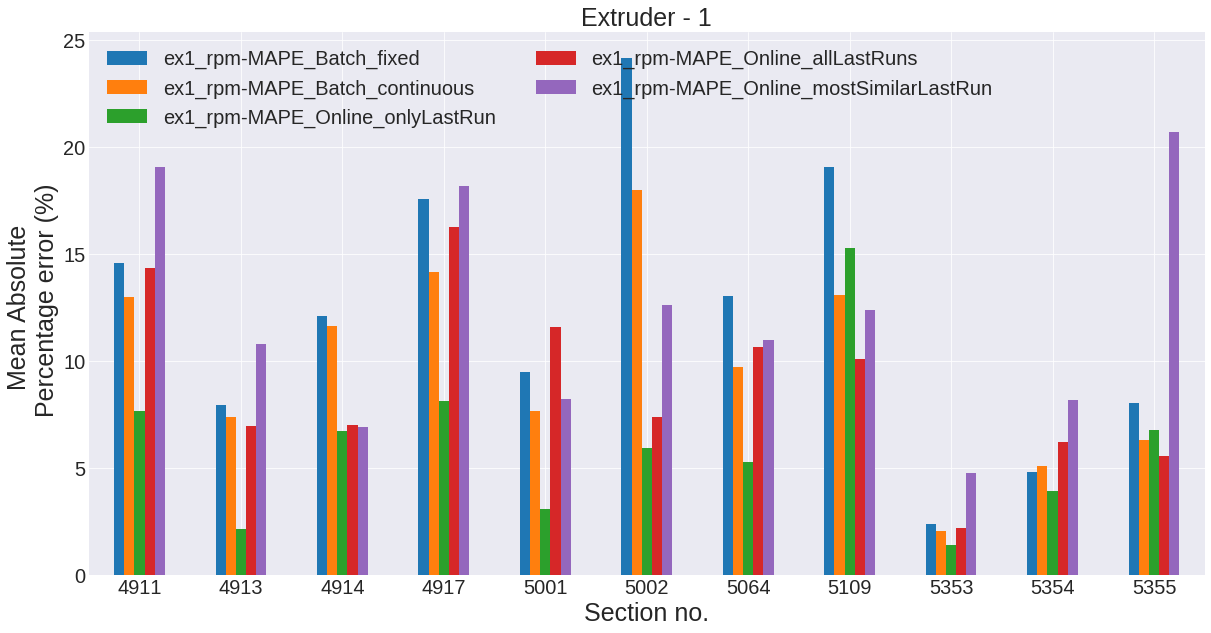

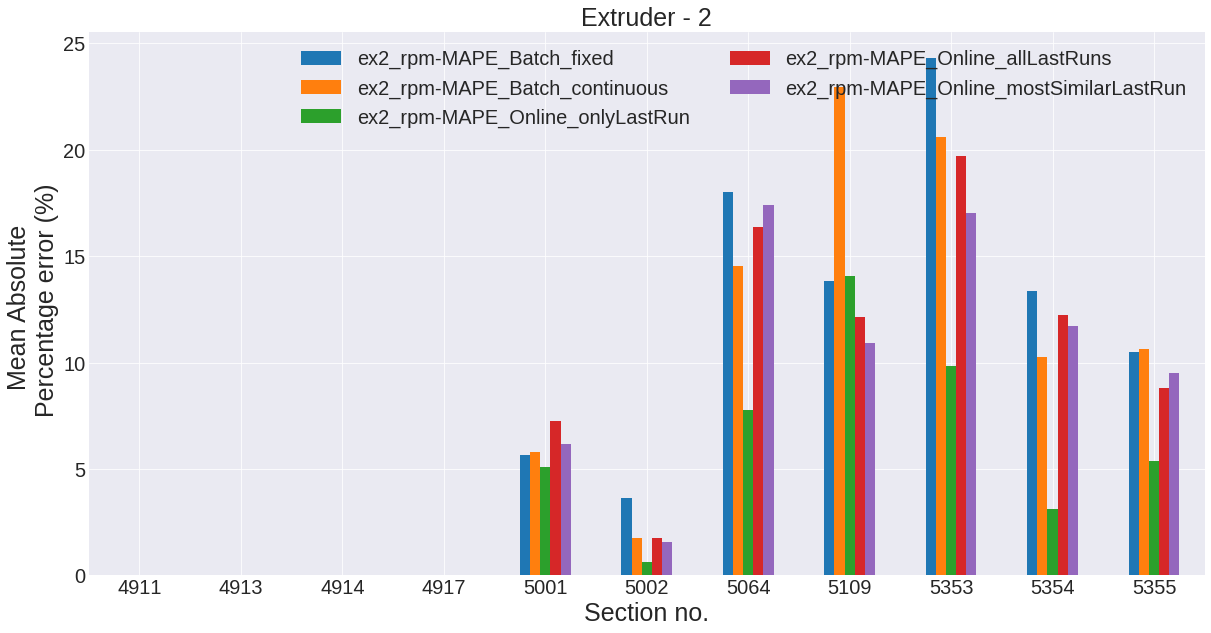

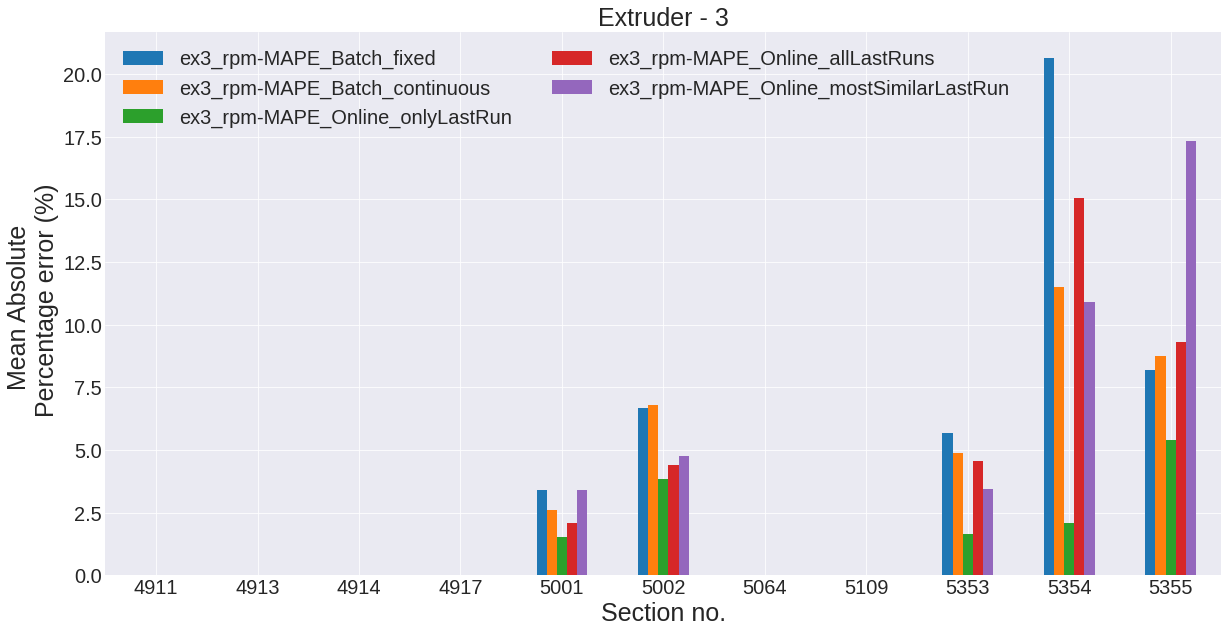

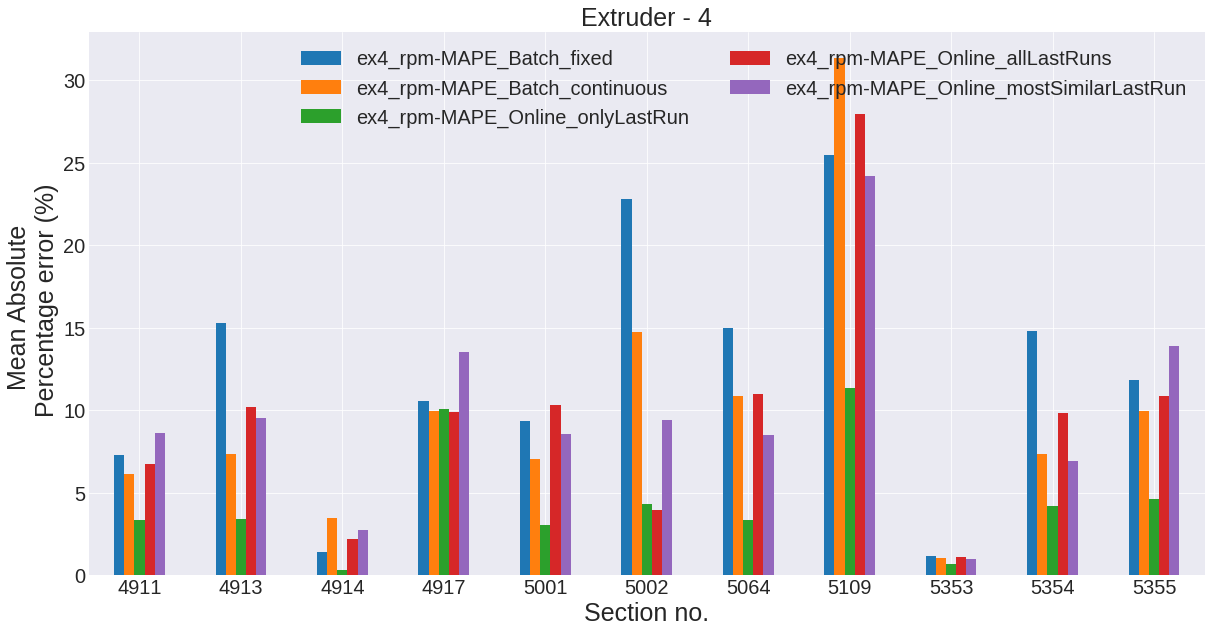

In [ ]:
plt.style.use('seaborn-darkgrid');
for extruder_no in range(1,5):
  params = {'legend.fontsize': 20}
  plot.rcParams.update(params)
  # fig,ax= plt.figure(figsize=(20,10));
  # plt.figure(figsize=(80, 60));
  ax = merged_final.plot.bar(x='section_id', y=['ex'+ str(extruder_no) +'_rpm-MAPE_Batch_fixed','ex' + str(extruder_no) + '_rpm-MAPE_Batch_continuous',\
                                                'ex' + str(extruder_no) + '_rpm-MAPE_Online_onlyLastRun', 'ex' + str(extruder_no) + '_rpm-MAPE_Online_allLastRuns',\
                                                'ex' + str(extruder_no) + '_rpm-MAPE_Online_mostSimilarLastRun'], rot=0, figsize=(20,10), fontsize = 40)
  plt.setp(ax.get_xticklabels(), fontsize=20);
  plt.setp(ax.get_yticklabels(), fontsize=20);
  ax.set_xlabel('Section no.', fontsize=25);
  ax.set_ylabel('Mean Absolute \n Percentage error (%)', fontsize=25);
  ax.set_title('Extruder - ' + str(extruder_no), fontsize=25);
  ax.legend(loc=0, ncol=2)


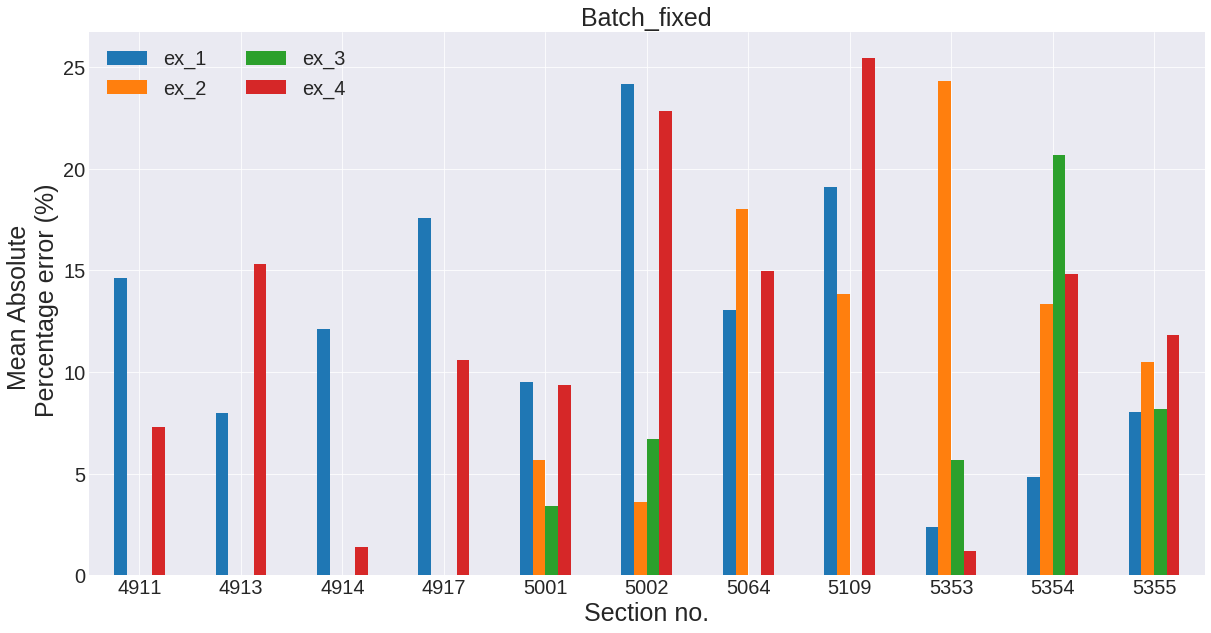

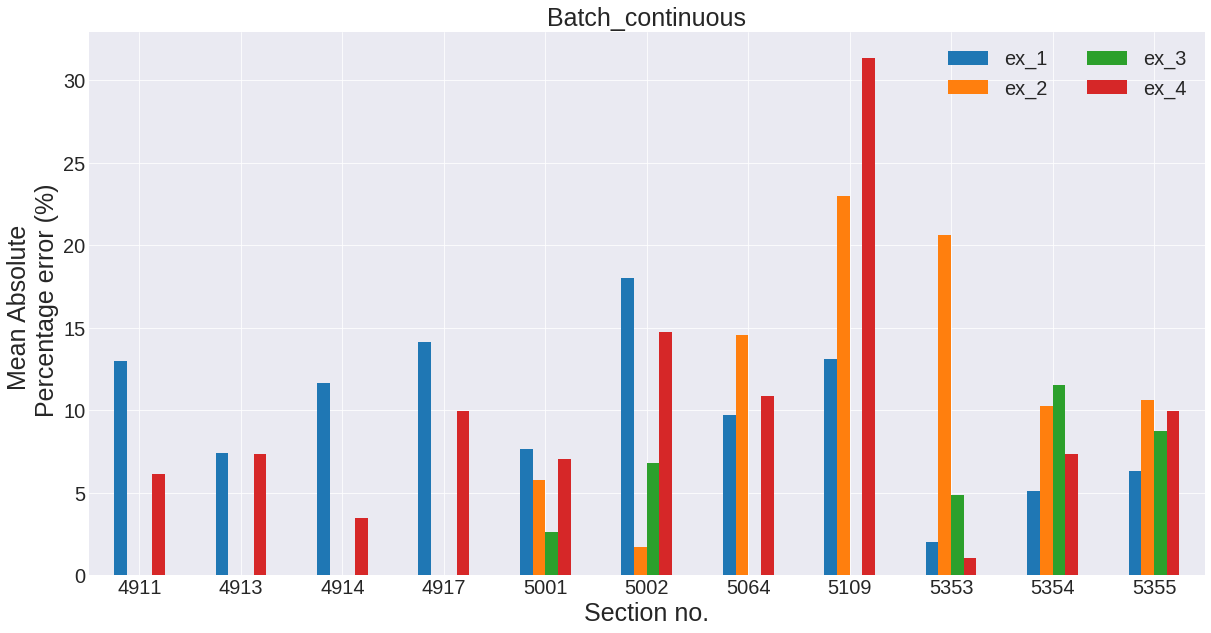

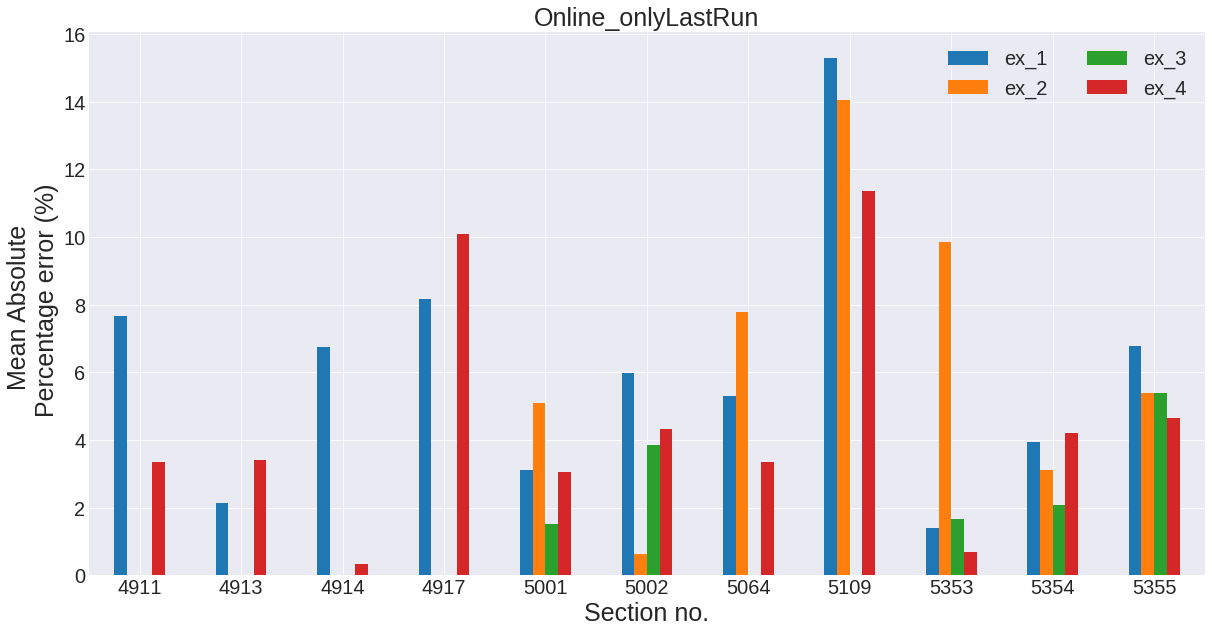

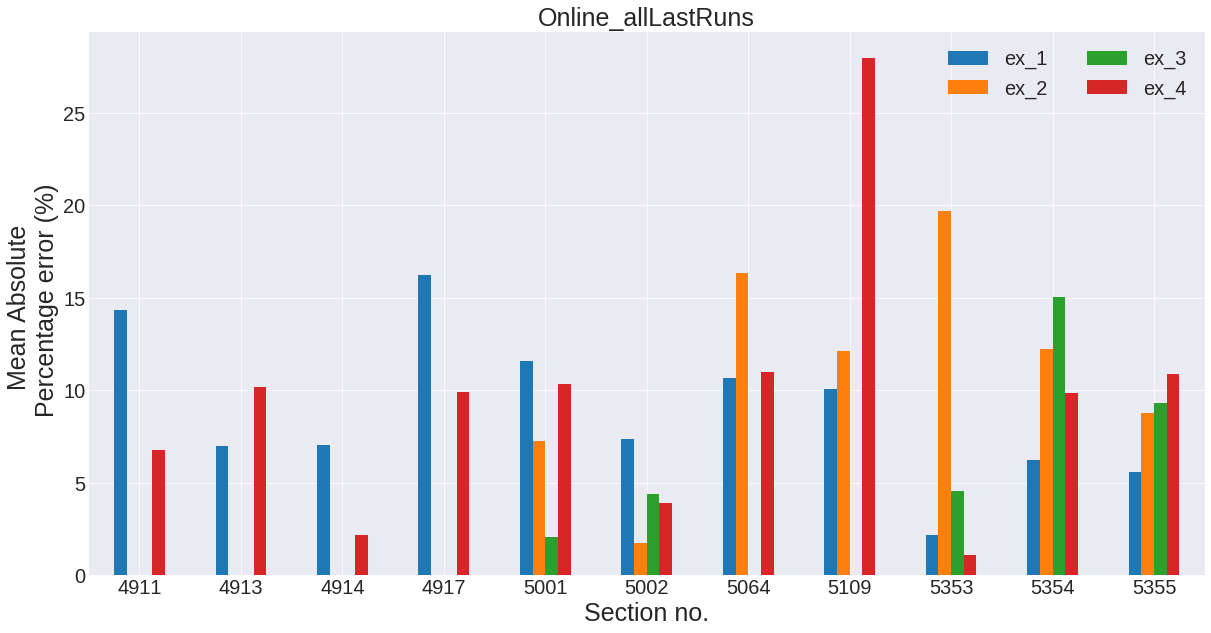

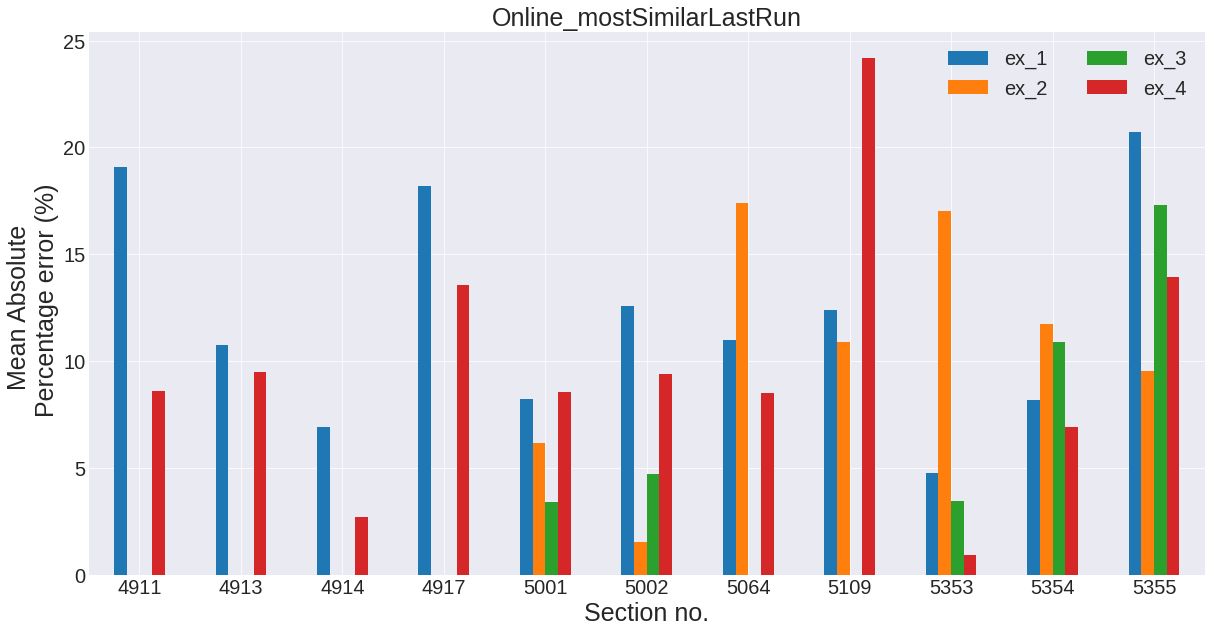

In [ ]:
list_of_methods = ['Batch_fixed', 'Batch_continuous', 'Online_onlyLastRun', 'Online_allLastRuns', 'Online_mostSimilarLastRun']

for method in list_of_methods:

  params = {'legend.fontsize': 20}
  plot.rcParams.update(params)

  ax = merged_final.plot.bar(x='section_id', y=['ex1_rpm-MAPE_' + method, 'ex2_rpm-MAPE_'+ method,'ex3_rpm-MAPE_'+ method,'ex4_rpm-MAPE_'+ method], rot=0, figsize=(20,10), fontsize = 40)
  plt.setp(ax.get_xticklabels(), fontsize=20);
  plt.setp(ax.get_yticklabels(), fontsize=20);
  ax.set_xlabel('Section no.', fontsize=25);
  ax.set_ylabel('Mean Absolute \n Percentage error (%)', fontsize=25);
  ax.set_title(method, fontsize=25);
  ax.legend(['ex_1','ex_2','ex_3','ex_4'],loc=0, ncol=2)
  

## Storing everything in an excel file!

In [ ]:
workbookname = 'output_stage2.xlsx'
workbook = xlsxwriter.Workbook(workbookname)
worksheet = workbook.add_worksheet()

workbook.close()

In [ ]:
if stage ==1:
  cols_save = [ 'ex1_t5', 'ex1_mixage', 'ex1_viscosity', 'ex2_t5', 'ex2_mixage', 'ex2_viscosity','ex3_t5', 'ex3_mixage', 'ex3_viscosity','ex4_t5', 'ex4_mixage', 'ex4_viscosity',\
              'ex1_rpm-true','ex1_rpm-predicted_Batch_fixed', 'ex1_rpm-predicted_Batch_continuous', 'ex1_rpm-predicted_Online_onlyLastRun', 'ex1_rpm-predicted_Online_allLastRuns', 'ex1_rpm-predicted_Online_mostSimilarLastRun',\
              'ex2_rpm-true','ex2_rpm-predicted_Batch_fixed', 'ex2_rpm-predicted_Batch_continuous', 'ex2_rpm-predicted_Online_onlyLastRun', 'ex2_rpm-predicted_Online_allLastRuns', 'ex2_rpm-predicted_Online_mostSimilarLastRun',\
              'ex3_rpm-true','ex3_rpm-predicted_Batch_fixed', 'ex3_rpm-predicted_Batch_continuous', 'ex3_rpm-predicted_Online_onlyLastRun', 'ex3_rpm-predicted_Online_allLastRuns', 'ex3_rpm-predicted_Online_mostSimilarLastRun',\
              'ex4_rpm-true','ex4_rpm-predicted_Batch_fixed', 'ex4_rpm-predicted_Batch_continuous', 'ex4_rpm-predicted_Online_onlyLastRun', 'ex4_rpm-predicted_Online_allLastRuns', 'ex4_rpm-predicted_Online_mostSimilarLastRun',\
              'start_time', 'run_time', 'extr_time','title_run']
else:
    cols_save = [ 'ex1_t5', 'ex1_mixage', 'ex1_viscosity', 'ex1_head_pressure', 'ex2_t5', 'ex2_mixage', 'ex2_viscosity', 'ex2_head_pressure', \
                 'ex3_t5', 'ex3_mixage', 'ex3_viscosity', 'ex3_head_pressure','ex4_t5', 'ex4_mixage', 'ex4_viscosity','ex4_head_pressure',\
              'ex1_rpm-true','ex1_rpm-predicted_Batch_fixed', 'ex1_rpm-predicted_Batch_continuous', 'ex1_rpm-predicted_Online_onlyLastRun', 'ex1_rpm-predicted_Online_allLastRuns', 'ex1_rpm-predicted_Online_mostSimilarLastRun',\
              'ex2_rpm-true','ex2_rpm-predicted_Batch_fixed', 'ex2_rpm-predicted_Batch_continuous', 'ex2_rpm-predicted_Online_onlyLastRun', 'ex2_rpm-predicted_Online_allLastRuns', 'ex2_rpm-predicted_Online_mostSimilarLastRun',\
              'ex3_rpm-true','ex3_rpm-predicted_Batch_fixed', 'ex3_rpm-predicted_Batch_continuous', 'ex3_rpm-predicted_Online_onlyLastRun', 'ex3_rpm-predicted_Online_allLastRuns', 'ex3_rpm-predicted_Online_mostSimilarLastRun',\
              'ex4_rpm-true','ex4_rpm-predicted_Batch_fixed', 'ex4_rpm-predicted_Batch_continuous', 'ex4_rpm-predicted_Online_onlyLastRun', 'ex4_rpm-predicted_Online_allLastRuns', 'ex4_rpm-predicted_Online_mostSimilarLastRun',\
              'start_time', 'run_time', 'extr_time','title_run']

for ind_test in range(merged_final.shape[0]):  # loop for all sections!
  df_test_results_copyPaste = pd.DataFrame(columns = cols_save) #defining a new data frame

  for exno in range(1,5):
    df_test_results_copyPaste['ex'+ str(exno) +'_rpm-true'] = merged_final['ex' + str(exno) + '_rpm-true_Batch_fixed'][ind_test]

  df_test_results_copyPaste['ex1_rpm-predicted_Batch_fixed'] = merged_final['ex1_rpm-predicted_Batch_fixed'][ind_test]
  df_test_results_copyPaste['ex1_rpm-predicted_Batch_continuous'] = merged_final['ex1_rpm-predicted_Batch_continuous'][ind_test]

  df_test_results_copyPaste['ex2_rpm-predicted_Batch_fixed'] = merged_final['ex2_rpm-predicted_Batch_fixed'][ind_test]
  df_test_results_copyPaste['ex2_rpm-predicted_Batch_continuous'] = merged_final['ex2_rpm-predicted_Batch_continuous'][ind_test]

  df_test_results_copyPaste['ex3_rpm-predicted_Batch_fixed'] = merged_final['ex3_rpm-predicted_Batch_fixed'][ind_test]
  df_test_results_copyPaste['ex3_rpm-predicted_Batch_continuous'] = merged_final['ex3_rpm-predicted_Batch_continuous'][ind_test]

  df_test_results_copyPaste['ex4_rpm-predicted_Batch_fixed'] = merged_final['ex4_rpm-predicted_Batch_fixed'][ind_test]
  df_test_results_copyPaste['ex4_rpm-predicted_Batch_continuous'] = merged_final['ex4_rpm-predicted_Batch_continuous'][ind_test]

  with open(dataPath + '/' + str(df_test_results['section_id'][ind_test])+'.pickle', 'rb') as handle:
      loaded_dict = pickle.load(handle)
  
  inputX = loaded_dict['inputs'][stage] 
  outputY = loaded_dict['outputs']
  groups = loaded_dict['title_run']

  #remove duplicates!
  inputX.drop_duplicates(inplace=True, keep="first") 
  outputY = outputY.loc[inputX.index,:]
  groups = groups.loc[inputX.index] 

  df_test_results_copyPaste['title_run'] = list(loaded_dict['title_run'].loc[inputX.index])
  df_test_results_copyPaste['start_time'] = list(loaded_dict['start_time'].loc[inputX.index].astype(str))
  df_test_results_copyPaste['run_time'] = list((loaded_dict['end_time'].loc[inputX.index] - loaded_dict['start_time'].loc[inputX.index]).astype('timedelta64[m]').astype(str))
  df_test_results_copyPaste['extr_time'] = list(loaded_dict['extr_time'].loc[inputX.index].astype(str))

  for k in loaded_dict['inputs'][1].columns:
    df_test_results_copyPaste[k] = list(loaded_dict['inputs'][stage][k].loc[inputX.index])

  df_test_results_copyPaste[['ex1_rpm-predicted_Online_onlyLastRun','ex2_rpm-predicted_Online_onlyLastRun','ex3_rpm-predicted_Online_onlyLastRun','ex4_rpm-predicted_Online_onlyLastRun']] = dict_results_lastrun[merged_final['section_id'][ind_test]]
  df_test_results_copyPaste[['ex1_rpm-predicted_Online_allLastRuns','ex2_rpm-predicted_Online_allLastRuns','ex3_rpm-predicted_Online_allLastRuns','ex4_rpm-predicted_Online_allLastRuns']] = dict_results_pastRunsAll[merged_final['section_id'][ind_test]]
  df_test_results_copyPaste[['ex1_rpm-predicted_Online_mostSimilarLastRun','ex2_rpm-predicted_Online_mostSimilarLastRun','ex3_rpm-predicted_Online_mostSimilarLastRun','ex4_rpm-predicted_Online_mostSimilarLastRun']] = dict_results_similarrun[merged_final['section_id'][ind_test]]
  
  with pd.ExcelWriter(workbookname, mode='a',engine="openpyxl") as writer:  
    df_test_results_copyPaste.to_excel(writer, sheet_name=str(merged_final['section_id'][ind_test]),index=False) 

ValueError: ignored